In [1]:
#collecting data
import numpy as np
import scipy.io
mat = scipy.io.loadmat('toy_dataset.mat') #dataset_connected_NYCwhile tryin in terminal, start path with Documents

## Preprocessing data

In [7]:
#friendship_new = mat['friendship_new']
friendship_old = mat['toy_friendship_old']
selected_checkins = mat['toy_checkins']
selected_users_IDs = mat['toy_users_IDs']
#temp = mat['selected_venue_IDs']
#selected_venue_IDs = []
#for i in range(len(temp)):
#    temper = temp[i][0]
#    selected_venue_IDs.append(temper[0])
#print(len(selected_venue_IDs)) #sanity check
#print(len(temp)) #should be same as above
print(max(selected_users_IDs))
print(len(selected_users_IDs))
#print(max(map(max, selected_checkins)))
print(len(selected_checkins))
print(max(map(max, friendship_old)))
print(len(friendship_old))
#max value in friendships should be same or less than the length of user_IDs

[4173]
5
5
5
3


In [8]:
# 1. rebuild node index
offset1 = max(selected_checkins[:,0]);
dumy, dumy, n = np.unique(selected_checkins[:,1],return_index=True,return_inverse=True, axis=0)
selected_checkins[:,1] = n+offset1;
#print(selected_checkins[:,1])
#print(offset1)
#print(n)
offset2 = max(selected_checkins[:,1]);
dumy, dumy, n = np.unique(selected_checkins[:,2],return_index=True,return_inverse=True, axis=0)
selected_checkins[:,2] = n+offset2;
#print(selected_checkins[:,2])
#print(offset2)
#print(n)
offset3 = max(selected_checkins[:,2]);
dumy, dumy, n = np.unique(selected_checkins[:,3],return_index=True,return_inverse=True, axis=0)
selected_checkins[:,3] = n+offset3;
#print(selected_checkins[:,3])
#print(offset3)
#print(n)

num_node_total = max(map(max, selected_checkins)) #max of the entire matrix = 8117
#print(min(map(min, selected_checkins)))

In [9]:
# 2. prepare checkins per user (fast)
#user_chechkins is a cell in MATLAB; using Python List for the same
user_checkins = [[] for _ in range(selected_users_IDs.shape[0])]
user_checkins_counter=np.zeros((len(selected_users_IDs),1)).astype(np.int64)
ind = selected_checkins[:,0].argsort(axis=0)
temp_checkins = np.array([selected_checkins[i,:] for i in ind]) #will not exactly be similar to MATLAB op
u,m,n = np.unique(temp_checkins[:,0],return_index=True,return_inverse=True, axis=0)
m=m.reshape(-1,1)
u=np.array(u)
print(u.shape)
counters = np.vstack((m[1:],temp_checkins.shape[0]))-m #+1 is not there because indexing starts from 0
ini_val=0
for i in range(0,u.shape[0]):
    user_checkins[u[i]-1].append(temp_checkins[ini_val:ini_val+counters[i,0],:])
    user_checkins[u[i]-1]=np.array(user_checkins[u[i]-1])[0,:,:].T
    user_checkins[u[i]-1].astype(np.int64)
    ini_val=ini_val+counters[i,0]
    user_checkins_counter[u[i]-1]=counters[i].astype(np.int64)
print(user_checkins[-1].shape) #for debugging

print(np.count_nonzero(user_checkins_counter)) #for debugging
len(user_checkins_counter)


(5,)
(4, 1)
5


5

In [10]:
# 3. random walk
from scipy.sparse import csr_matrix
num_node = len(selected_users_IDs)
print(num_node)
network=csr_matrix((np.ones((len(friendship_old),)), (friendship_old[:,0]-1, friendship_old[:,1]-1)), shape=(num_node, num_node))
network=network+network.T
print(network)

node_list=[[] for _ in range(num_node)]
node_list_len = np.zeros((num_node,));
num_walk = 10
len_walk = 80
(indx,indy) = network.T.nonzero()
#for i in range(len(indx)):
#    indx[i]+=1
#    indy[i]+=1

temp, m, n = np.unique(indx,return_index=True,return_inverse=True, axis=0) #check m for debugging
print(temp)
print(m)
print(n)
m=np.array(m).reshape(-1,1)
node_list_len=np.vstack((m[1:],len(indx))) - m #+1 is not there because indexing starts from 0
ini_val=0
temp=np.array(temp)
node_list_len=node_list_len[:,0] #for indexing

for i in range(0,temp.shape[0]):
    node_list[temp[i]].append(indy[ini_val:ini_val+node_list_len[i]])
    ini_val=ini_val+node_list_len[i]
node_list #for debugging match with MATLAB
#node_list_len.shape = np.count_nonzero(node_list_len) has to be as written in MATLAB script


5
  (0, 4)	1.0
  (1, 2)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
[0 1 2 3 4]
[0 1 2 4 5]
[0 1 2 2 3 4]


[[array([4], dtype=int32)],
 [array([2], dtype=int32)],
 [array([1, 3], dtype=int32)],
 [array([2], dtype=int32)],
 [array([0], dtype=int32)]]

In [11]:
# let's have a walk over social network (friendship)
import random
walks = np.zeros((num_walk*num_node,len_walk),dtype = np.int64);
for ww in range(num_walk):
    for ii in range(num_node):
        seq = np.zeros((len_walk,),dtype=int)
        seq[0] = ii
        current_e = ii
        for jj in range(len_walk-1):
            rand_ind = random.randint(0, node_list_len[seq[jj]]-1);
            tempvar = node_list[seq[jj]][0] 
            #print(node_list_len[seq[jj]])
            #print(rand_ind)
            #print(tempvar.shape)
            seq[jj+1] = tempvar[rand_ind];
        
        walks[ii+(ww-1)*num_node,:] = seq
        
#preprocessing for removing 0 quantities
for i in range(walks.shape[0]):
    for j in range(walks.shape[1]):
        walks[i,j] = walks[i,j] +1
#print(min(map(min, walks))) #should be 1 and 4024
print(walks)

[[1 5 1 ... 5 1 5]
 [2 3 4 ... 3 2 3]
 [3 4 3 ... 4 3 2]
 ...
 [3 2 3 ... 2 3 4]
 [4 3 2 ... 3 4 3]
 [5 1 5 ... 1 5 1]]


In [12]:
# 4. prepare negative sample table in advance (fast)
# social relationship
from collections import Counter
(dumy,r) = network.nonzero(); #MATLAB gives [y,x]; Python gives (x,y)
print(r.shape)
print(r)
temptab = Counter(r) #len(temptab) = size(tab_degree,1) #Counter gives unique elements in r
tab2= [[] for _ in range(len(temptab))]

for i in range(len(temptab)):
    tab2[i].append(temptab[i])
tab2=np.array(tab2)[:,0] #when printing temptab, not in asc. order but here it becomes asc. wrt keys

tab1=np.unique(r)
tab3=[[] for _ in range(len(tab1))]
tot=sum(tab2)
for i in range(len(tab1)):
    tab3[i]=round((tab2[i]*100)/tot,4)
tab_degree=np.stack((tab1,tab2,tab3),axis=1) # equivalent of tab_degree = tabulate(r) in MATLAB

freq = np.array([round(np.power(i,0.75),4) for i in tab_degree[:,2]] )
den=float(sum(freq))
neg_sam_table_social = np.repeat((1+tab_degree[:,0]),np.around(1000000*freq/sum(freq)).astype(np.int64))
neg_sam_table_social=neg_sam_table_social.astype(np.int64) # unigram with 0.75 power
#neg_sam_table_social[740] check for debugging
del temptab,tab1,tab2,tab3,tab_degree,freq,den
print(neg_sam_table_social)

(6,)
[4 2 1 3 2 0]
[1 1 1 ... 5 5 5]


In [13]:
#checkins: user, venue, time, semantic, with node type normalization for each node domain

neg_sam_table_mobility_norm = [[] for _ in range(4)]
for ii in range(len(neg_sam_table_mobility_norm)):
    tab1=np.array([elem for elem in range(max(temp_checkins[:,ii]))])#tab1 has all elements;even with frequency 0
    temptab = Counter(temp_checkins[:,ii]) #correct
    tab2= np.zeros((len(tab1),))
    for i in tab1:
        tab2[i]= temptab[i+1] #because in python, index starts from 0
    tab2 = np.array(tab2)
    tot=np.sum(tab2)
    tab3=np.zeros((len(tab1),))
    for i in range(len(tab1)):
        tab3[i]= np.round((tab2[i]*100)/tot,4) if (tot) else 0
    tab3=np.array(tab3)
    tab_degree=np.stack((tab1,tab2,tab3),axis=1)
    freq = np.array([np.round(np.power(i,0.75),4) for i in tab_degree[:,2]])
    den=float(sum(freq))
    ingoes = np.repeat((tab_degree[:,0]+1),np.around(100000*freq/sum(freq)).astype(np.int64))
    neg_sam_table_mobility_norm[ii].append(ingoes)

    del tab1,tab2,i,tab3,tab_degree,freq,ingoes,tot

neg_sam_table_mobility_norm = [np.array(x).astype(np.int64) for x in neg_sam_table_mobility_norm]

#neg_sam_table_mobility1 = neg_sam_table_mobility_norm[3][0]
#neg_sam_table_mobility1[5]
print(neg_sam_table_mobility_norm)

[array([[1, 1, 1, ..., 5, 5, 5]]), array([[5, 5, 5, ..., 9, 9, 9]]), array([[ 9,  9,  9, ..., 12, 12, 12]]), array([[12, 12, 12, ..., 15, 15, 15]])]


In [14]:
print(temp_checkins)


[[ 1  7  9 14]
 [ 2  8 11 13]
 [ 3  5  9 15]
 [ 4  9 10 12]
 [ 5  6 12 14]]


In [15]:
# LBSN2vec
dim_emb = 2 #128
num_epoch = 1
num_threads =  4
K_neg = 3 #10
win_size = 2 #10
learning_rate = 0.001


embs_ini = (np.random.uniform(size=(num_node_total,dim_emb))-0.5)/dim_emb 
temp = np.sum(np.power(embs_ini,2),axis=1)
embs_len = np.power(temp,0.5)
den = embs_len
for i in range(dim_emb-1):
    den=np.vstack((den,embs_len))
den=den.T
#print(den.shape)
#print(embs_ini.shape)
embs_ini = np.divide(embs_ini,den)

mobility_ratio = 0.2

In [16]:
import learn_LBSN2Vec_embedding

embs = learn_LBSN2Vec_embedding.driver_fn(walks.T,user_checkins, user_checkins_counter,embs_ini.T,learning_rate, 
                                K_neg,neg_sam_table_social, win_size, neg_sam_table_mobility_norm,
                                num_epoch, mobility_ratio);

this is num_w 50
this is num_wl 80
[[1 2 3 ... 3 4 5]
 [5 3 4 ... 2 3 1]
 [1 4 3 ... 3 2 5]
 ...
 [5 3 4 ... 2 3 1]
 [1 2 3 ... 3 4 5]
 [5 3 2 ... 4 3 1]]
time taken to learn hyperedge 0.05821191499999978
this is num_wl: 0 and num_w 0
[[ 0.90318911  0.52695065 -0.73971323 -0.99942799  0.62804098 -0.78157819
   0.93019298 -0.76102    -0.28063546  0.27793483  0.51876281 -0.65910158
  -0.9854992  -0.74914809 -0.84070261]
 [ 0.42924346 -0.84989623  0.67292224  0.03383222 -0.77818072  0.623808
   0.36707166 -0.64872842  0.95981477  0.96059993  0.85491824 -0.75205402
   0.16968006  0.66240319 -0.54149748]]
time taken to learn left window 0.0008508199999996968
time taken to learn right window 0.0008093639999997571
this is num_wl: 1 and num_w 0
[[ 0.90372012  0.52574043 -0.74037458 -0.99941516  0.62900404 -0.78157819
   0.93019298 -0.76102    -0.28063546  0.27793483  0.51876281 -0.65910158
  -0.9854992  -0.74914809 -0.84070261]
 [ 0.42812524 -0.85064599  0.67219489  0.03420996 -0.77740298  0.6

time taken to learn hyperedge 0.0008115260000001179
this is num_wl: 19 and num_w 2
[[ 0.91910751  0.50791226 -0.76113081 -0.99945624  0.65106518 -0.79701759
   0.92723809 -0.7557304  -0.25209936  0.28321791  0.52568166 -0.65694049
  -0.98637772 -0.74831637 -0.83499352]
 [ 0.39405683 -0.86143404  0.64862107  0.03321802 -0.75906888  0.60397588
   0.37448678 -0.6548874   0.96772374  0.9590596   0.8506852  -0.75395213
   0.16454297  0.66336555 -0.55026797]]
time taken to learn left window 0.0002558840000004281
time taken to learn right window 0.00019264300000010337
time taken to learn hyperedge 0.000917701000000104
this is num_wl: 20 and num_w 2
[[ 0.91910751  0.50791194 -0.76113216 -0.99945619  0.65106518 -0.79701715
   0.92723817 -0.75573006 -0.25210033  0.28321877  0.5256823  -0.65694002
  -0.98637772 -0.74831586 -0.83499375]
 [ 0.39405683 -0.86143423  0.64861948  0.03321942 -0.75906888  0.60397646
   0.37448659 -0.65488779  0.96772349  0.95905935  0.85068481 -0.75395254
   0.16454297  

time taken to learn hyperedge 0.0008263900000002877
this is num_wl: 68 and num_w 3
[[ 0.91911546  0.50784472 -0.76115857 -0.99945572  0.65113607 -0.79700725
   0.92724241 -0.75570625 -0.25209202  0.28322498  0.52570727 -0.65690962
  -0.98638006 -0.74828386 -0.835001  ]
 [ 0.3940383  -0.86147386  0.64858849  0.03323363 -0.75900807  0.60398953
   0.37447607 -0.65491525  0.96772566  0.95905752  0.85066938 -0.75397903
   0.16452891  0.66340223 -0.55025662]]
time taken to learn hyperedge 0.0008805440000001497
this is num_wl: 69 and num_w 3
[[ 0.91911569  0.50784472 -0.76115888 -0.99945572  0.65113561 -0.79700699
   0.92724241 -0.75570625 -0.25209115  0.28322593  0.52570807 -0.65690896
  -0.98638008 -0.74828386 -0.83500139]
 [ 0.39403777 -0.86147386  0.64858813  0.03323363 -0.75900846  0.60398987
   0.37447607 -0.65491525  0.96772588  0.95905724  0.85066888 -0.7539796
   0.16452882  0.66340223 -0.55025603]]
time taken to learn left window 0.0001902859999995954
time taken to learn right windo

time taken to learn hyperedge 0.0010113210000000095
this is num_wl: 22 and num_w 5
[[ 0.91913314  0.50780838 -0.76118254 -0.9994554   0.65115105 -0.79702498
   0.92723812 -0.75569994 -0.25204999  0.283234    0.52571925 -0.65690423
  -0.98637974 -0.74828322 -0.83499882]
 [ 0.39399706 -0.86149528  0.64856037  0.03324323 -0.75899521  0.60396614
   0.3744867  -0.65492254  0.9677366   0.95905485  0.85066198 -0.75398372
   0.16453084  0.66340294 -0.55025993]]
this is num_wl: 23 and num_w 5
[[ 0.91913314  0.50780838 -0.76118254 -0.9994554   0.65115105 -0.79702498
   0.92723812 -0.75569994 -0.25204999  0.283234    0.52571925 -0.65690423
  -0.98637974 -0.74828322 -0.83499882]
 [ 0.39399706 -0.86149528  0.64856037  0.03324323 -0.75899521  0.60396614
   0.3744867  -0.65492254  0.9677366   0.95905485  0.85066198 -0.75398372
   0.16453084  0.66340294 -0.55025993]]
time taken to learn hyperedge 0.0009389230000000914
this is num_wl: 24 and num_w 5
[[ 0.91913282  0.50780838 -0.76118312 -0.9994554   0.

time taken to learn hyperedge 0.0011182829999998312
this is num_wl: 1 and num_w 7
[[ 0.91914907  0.507756   -0.76122551 -0.99945451  0.65120586 -0.79702518
   0.92723989 -0.75568988 -0.25200947  0.28324878  0.5257284  -0.6568863
  -0.98638108 -0.74826749 -0.83499829]
 [ 0.39395989 -0.86152615  0.64850992  0.03326984 -0.75894819  0.60396586
   0.37448232 -0.65493415  0.96774716  0.95905049  0.85065632 -0.75399934
   0.1645228   0.66342069 -0.55026074]]
time taken to learn left window 0.0002559620000002205
time taken to learn right window 0.0002253940000001009
this is num_wl: 2 and num_w 7
[[ 0.91914907  0.50775568 -0.76122637 -0.9994545   0.65120586 -0.79702518
   0.92723989 -0.75568988 -0.25200947  0.28324878  0.5257284  -0.6568863
  -0.98638108 -0.74826749 -0.83499829]
 [ 0.39395989 -0.86152634  0.64850892  0.03327017 -0.75894819  0.60396586
   0.37448232 -0.65493415  0.96774716  0.95905049  0.85065632 -0.75399934
   0.1645228   0.66342069 -0.55026074]]
time taken to learn left window

   0.16451449  0.66344088 -0.55025393]]
this is num_wl: 14 and num_w 8
[[ 0.91914685  0.50768741 -0.76126077 -0.99945401  0.65126699 -0.79701658
   0.92724122 -0.755682   -0.25199485  0.28325558  0.5257372  -0.65687298
  -0.98638247 -0.74824959 -0.83500278]
 [ 0.39396506 -0.86156657  0.64846854  0.03328497 -0.75889573  0.60397722
   0.37447904 -0.65494324  0.96775096  0.95904848  0.85065088 -0.75401095
   0.16451449  0.66344088 -0.55025393]]
time taken to learn hyperedge 0.0011928949999999716
this is num_wl: 15 and num_w 8
[[ 0.91914695  0.50768822 -0.76126126 -0.99945401  0.65126699 -0.79701658
   0.9272413  -0.75568166 -0.25199485  0.28325558  0.52573784 -0.6568725
  -0.98638247 -0.74824959 -0.835003  ]
 [ 0.39396485 -0.8615661   0.64846796  0.03328497 -0.75889573  0.60397722
   0.37447884 -0.65494363  0.96775096  0.95904848  0.85065049 -0.75401137
   0.16451449  0.66344088 -0.55025359]]
time taken to learn left window 0.0002997589999997885
time taken to learn right window 0.00029035

this is num_wl: 46 and num_w 9
[[ 0.91915926  0.50764627 -0.76130907 -0.99945318  0.65130952 -0.79701892
   0.92723965 -0.75567295 -0.25195656  0.28326667  0.52574448 -0.65685895
  -0.98638455 -0.74822945 -0.8350068 ]
 [ 0.39393611 -0.86159082  0.64841183  0.03330988 -0.75885923  0.60397413
   0.37448291 -0.65495368  0.96776093  0.95904521  0.85064638 -0.75402317
   0.16450202  0.6634636  -0.55024782]]
this is num_wl: 47 and num_w 9
[[ 0.91915926  0.50764627 -0.76130907 -0.99945318  0.65130952 -0.79701892
   0.92723965 -0.75567295 -0.25195656  0.28326667  0.52574448 -0.65685895
  -0.98638455 -0.74822945 -0.8350068 ]
 [ 0.39393611 -0.86159082  0.64841183  0.03330988 -0.75885923  0.60397413
   0.37448291 -0.65495368  0.96776093  0.95904521  0.85064638 -0.75402317
   0.16450202  0.6634636  -0.55024782]]
time taken to learn left window 0.0005990879999995258
time taken to learn right window 0.0003775099999998588
this is num_wl: 48 and num_w 9
[[ 0.91915973  0.50764502 -0.76130967 -0.9994531

time taken to learn left window 0.0005193300000003731
time taken to learn right window 0.00037599599999982303
time taken to learn hyperedge 0.0015552709999999692
this is num_wl: 2 and num_w 11
[[ 0.91918101  0.50761045 -0.76134186 -0.9994527   0.65133356 -0.79704124
   0.92723424 -0.75566853 -0.25190963  0.28327179  0.52575441 -0.65685761
  -0.98638569 -0.74822776 -0.83500238]
 [ 0.39388536 -0.86161192  0.64837333  0.03332433 -0.75883861  0.60394467
   0.37449631 -0.65495879  0.96777315  0.95904369  0.85064025 -0.75402434
   0.16449519  0.66346549 -0.55025453]]
this is num_wl: 3 and num_w 11
[[ 0.91918101  0.50761045 -0.76134186 -0.9994527   0.65133356 -0.79704124
   0.92723424 -0.75566853 -0.25190963  0.28327179  0.52575441 -0.65685761
  -0.98638569 -0.74822776 -0.83500238]
 [ 0.39388536 -0.86161192  0.64837333  0.03332433 -0.75883861  0.60394467
   0.37449631 -0.65495879  0.96777315  0.95904369  0.85064025 -0.75402434
   0.16449519  0.66346549 -0.55025453]]
time taken to learn hypere

time taken to learn hyperedge 0.0016781850000002763
this is num_wl: 76 and num_w 11
[[ 0.91918666  0.50759785 -0.76136465 -0.99945218  0.65136953 -0.79703618
   0.92723929 -0.75565682 -0.25191412  0.2832728   0.52576553 -0.65684489
  -0.98638668 -0.74821549 -0.83500295]
 [ 0.39387219 -0.86161935  0.64834657  0.03333986 -0.75880773  0.60395135
   0.37448381 -0.65497229  0.96777198  0.95904339  0.85063338 -0.75403542
   0.16448926  0.66347934 -0.55025367]]
time taken to learn left window 0.00038784799999991293
time taken to learn right window 0.0004694069999997552
time taken to learn hyperedge 0.0017061920000003283
this is num_wl: 77 and num_w 11
[[ 0.91918682  0.50759753 -0.76136575 -0.99945215  0.65136953 -0.79703618
   0.92723953 -0.75565571 -0.25191494  0.28327472  0.52576553 -0.6568442
  -0.9863867  -0.74821495 -0.83500337]
 [ 0.39387181 -0.86161953  0.64834527  0.03334086 -0.75880773  0.60395135
   0.37448322 -0.65497358  0.96777177  0.95904283  0.85063338 -0.75403602
   0.16448912

time taken to learn right window 0.0004036000000002815
time taken to learn hyperedge 0.001679750000000091
this is num_wl: 14 and num_w 13
[[ 0.91919377  0.50755719 -0.7613932  -0.99945143  0.65141251 -0.79702419
   0.92724365 -0.75564026 -0.25191401  0.2832835   0.52578469 -0.65682295
  -0.98638753 -0.74818772 -0.83500999]
 [ 0.39385557 -0.86164329  0.64831304  0.03336231 -0.75877083  0.60396718
   0.37447301 -0.65499139  0.96777201  0.95904023  0.85062153 -0.75405453
   0.16448416  0.66351065 -0.55024298]]
this is num_wl: 15 and num_w 13
[[ 0.91919377  0.50755719 -0.7613932  -0.99945143  0.65141251 -0.79702419
   0.92724365 -0.75564026 -0.25191401  0.2832835   0.52578469 -0.65682295
  -0.98638753 -0.74818772 -0.83500999]
 [ 0.39385557 -0.86164329  0.64831304  0.03336231 -0.75877083  0.60396718
   0.37447301 -0.65499139  0.96777201  0.95904023  0.85062153 -0.75405453
   0.16448416  0.66351065 -0.55024298]]
time taken to learn hyperedge 0.001953867000000109
this is num_wl: 16 and num_w 

time taken to learn hyperedge 0.0017443119999995815
this is num_wl: 39 and num_w 14
[[ 0.91920397  0.5075173  -0.76143136 -0.99945071  0.65144659 -0.79702277
   0.92724145 -0.75563237 -0.25188135  0.28330391  0.52579429 -0.65680304
  -0.98639021 -0.74815937 -0.83501385]
 [ 0.39383177 -0.86166679  0.64826822  0.03338401 -0.75874157  0.60396905
   0.37447846 -0.6550005   0.96778051  0.9590342   0.8506156  -0.75407187
   0.16446807  0.66354262 -0.55023713]]
time taken to learn left window 0.0004229050000006396
time taken to learn right window 0.0004131770000004309
this is num_wl: 40 and num_w 14
[[ 0.91920444  0.5075173  -0.76143196 -0.99945071  0.65144749 -0.79702277
   0.92724145 -0.75563237 -0.25188135  0.28330391  0.52579429 -0.65680304
  -0.98639021 -0.74815937 -0.83501385]
 [ 0.39383068 -0.86166679  0.64826752  0.03338401 -0.7587408   0.60396905
   0.37447846 -0.6550005   0.96778051  0.9590342   0.8506156  -0.75407187
   0.16446807  0.66354262 -0.55023713]]
time taken to learn left 

time taken to learn left window 0.0004336529999999783
time taken to learn right window 0.00042690299999925685
time taken to learn hyperedge 0.0019048969999992948
this is num_wl: 77 and num_w 15
[[ 0.91922663  0.50747864 -0.76146406 -0.99945056  0.65146781 -0.79704059
   0.92723579 -0.75562814 -0.25183976  0.28331223  0.52579994 -0.65680205
  -0.98639284 -0.74815231 -0.83500891]
 [ 0.39377889 -0.86168956  0.64822981  0.03338833 -0.75872335  0.60394552
   0.37449246 -0.65500538  0.96779133  0.95903175  0.8506121  -0.75407274
   0.16445233  0.66355057 -0.55024462]]
this is num_wl: 78 and num_w 15
[[ 0.91922663  0.50747864 -0.76146406 -0.99945056  0.65146781 -0.79704059
   0.92723579 -0.75562814 -0.25183976  0.28331223  0.52579994 -0.65680205
  -0.98639284 -0.74815231 -0.83500891]
 [ 0.39377889 -0.86168956  0.64822981  0.03338833 -0.75872335  0.60394552
   0.37449246 -0.65500538  0.96779133  0.95903175  0.8506121  -0.75407274
   0.16445233  0.66355057 -0.55024462]]
time taken to learn left

time taken to learn right window 0.0004939220000004241
this is num_wl: 35 and num_w 17
[[ 0.91923481  0.50744514 -0.76149585 -0.99944987  0.651522   -0.79702515
   0.92723871 -0.75561564 -0.25183096  0.28331698  0.52581864 -0.65678795
  -0.98639391 -0.74813329 -0.83501076]
 [ 0.39375979 -0.86170929  0.64819246  0.03340901 -0.75867682  0.60396591
   0.37448524 -0.6550198   0.96779363  0.95903034  0.85060054 -0.75408502
   0.16444586  0.66357202 -0.55024182]]
this is num_wl: 36 and num_w 17
[[ 0.91923481  0.50744514 -0.76149585 -0.99944987  0.651522   -0.79702515
   0.92723871 -0.75561564 -0.25183096  0.28331698  0.52581864 -0.65678795
  -0.98639391 -0.74813329 -0.83501076]
 [ 0.39375979 -0.86170929  0.64819246  0.03340901 -0.75867682  0.60396591
   0.37448524 -0.6550198   0.96779363  0.95903034  0.85060054 -0.75408502
   0.16444586  0.66357202 -0.55024182]]
time taken to learn left window 0.0005286359999994161
this is num_wl: 37 and num_w 17
[[ 0.91923458  0.50744439 -0.76149457 -0.9994

time taken to learn right window 0.0005010159999994102
this is num_wl: 42 and num_w 18
[[ 0.919238    0.50740762 -0.76152424 -0.99944912  0.65155854 -0.79701599
   0.92724143 -0.75560608 -0.25181622  0.2833262   0.52583029 -0.65677138
  -0.98639508 -0.74811322 -0.83501549]
 [ 0.39375234 -0.86173138  0.64815911  0.03343137 -0.75864544  0.60397799
   0.3744785  -0.65503083  0.96779746  0.95902762  0.85059334 -0.75409944
   0.16443889  0.66359465 -0.55023463]]
this is num_wl: 43 and num_w 18
[[ 0.919238    0.50740762 -0.76152424 -0.99944912  0.65155854 -0.79701599
   0.92724143 -0.75560608 -0.25181622  0.2833262   0.52583029 -0.65677138
  -0.98639508 -0.74811322 -0.83501549]
 [ 0.39375234 -0.86173138  0.64815911  0.03343137 -0.75864544  0.60397799
   0.3744785  -0.65503083  0.96779746  0.95902762  0.85059334 -0.75409944
   0.16443889  0.66359465 -0.55023463]]
time taken to learn right window 0.0006766209999993222
time taken to learn hyperedge 0.0023738509999997603
this is num_wl: 44 and n

time taken to learn left window 0.0007501919999999274
time taken to learn right window 0.0006308840000004423
this is num_wl: 74 and num_w 19
[[ 0.91924677  0.50736393 -0.76155362 -0.99944919  0.65159147 -0.79702301
   0.92723799 -0.75559809 -0.251777    0.28333845  0.52584384 -0.6567624
  -0.98639682 -0.7480996  -0.83501117]
 [ 0.39373186 -0.86175711  0.6481246   0.03342929 -0.75861715  0.60396873
   0.37448702 -0.65504005  0.96780767  0.959024    0.85058497 -0.75410727
   0.16442843  0.66361    -0.5502412 ]]
time taken to learn left window 0.0005609819999996546
time taken to learn right window 0.0005458770000004165
time taken to learn hyperedge 0.002401928000000275
this is num_wl: 75 and num_w 19
[[ 0.91924706  0.50736312 -0.76155421 -0.99944919  0.65159087 -0.79702301
   0.92723782 -0.75559799 -0.251777    0.28333845  0.52584359 -0.6567624
  -0.98639682 -0.74809894 -0.83501101]
 [ 0.39373119 -0.86175759  0.6481239   0.03342929 -0.75861767  0.60396873
   0.37448745 -0.65504017  0.9678

time taken to learn hyperedge 0.002518080999999839
this is num_wl: 14 and num_w 21
[[ 0.9192628   0.50732826 -0.76158451 -0.99944871  0.65162275 -0.79703888
   0.92723383 -0.75559124 -0.25173482  0.28334815  0.525853   -0.6567556
  -0.98639816 -0.74809698 -0.83500907]
 [ 0.39369445 -0.86177811  0.6480883   0.03344372 -0.75859029  0.60394779
   0.37449733 -0.65504794  0.96781864  0.95902113  0.8505793  -0.75411319
   0.16442041  0.66361296 -0.55024438]]
time taken to learn left window 0.0006129939999999223
time taken to learn right window 0.0006058830000004178
time taken to learn hyperedge 0.002478634000000035
this is num_wl: 15 and num_w 21
[[ 0.91926321  0.50732799 -0.76158561 -0.9994487   0.65162498 -0.79703888
   0.92723407 -0.75559124 -0.25173482  0.28334815  0.525853   -0.6567556
  -0.9863982  -0.74809698 -0.83500949]
 [ 0.39369347 -0.86177827  0.648087    0.03344405 -0.75858837  0.60394779
   0.37449674 -0.65504794  0.96781864  0.95902113  0.8505793  -0.75411319
   0.16442014  0.

time taken to learn hyperedge 0.0024656910000002696
this is num_wl: 28 and num_w 22
[[ 0.91926947  0.50730591 -0.76160015 -0.99944826  0.65165775 -0.79702946
   0.92723714 -0.75557664 -0.25172895  0.28334442  0.52587093 -0.65674128
  -0.98639917 -0.74807933 -0.83501116]
 [ 0.39367887 -0.86179126  0.64806992  0.0334573  -0.75856022  0.60396022
   0.37448914 -0.65506478  0.96782016  0.95902224  0.85056822 -0.75412566
   0.16441435  0.66363285 -0.55024121]]
time taken to learn hyperedge 0.0025382529999999903
this is num_wl: 29 and num_w 22
[[ 0.91926947  0.50730633 -0.76160003 -0.99944824  0.65165799 -0.79702946
   0.92723773 -0.75557664 -0.25172963  0.28334349  0.52587263 -0.65674128
  -0.98639922 -0.7480792  -0.83501067]
 [ 0.39367887 -0.86179101  0.64807005  0.03345777 -0.75856001  0.60396022
   0.37448767 -0.65506478  0.96781999  0.95902251  0.85056717 -0.75412566
   0.164414    0.663633   -0.55024196]]
this is num_wl: 30 and num_w 22
[[ 0.91926947  0.50730633 -0.76160003 -0.99944824 

time taken to learn hyperedge 0.0026892830000004864
this is num_wl: 15 and num_w 23
[[ 0.91927466  0.5072764  -0.76161903 -0.99944805  0.65169279 -0.7970219
   0.92724115 -0.75556805 -0.2517217   0.2833438   0.52588125 -0.6567302
  -0.98640014 -0.74805928 -0.83501405]
 [ 0.39366674 -0.86180863  0.64804772  0.03346344 -0.75853012  0.6039702
   0.37447921 -0.6550747   0.96782205  0.95902242  0.85056184 -0.75413531
   0.16440849  0.66365545 -0.55023682]]
time taken to learn hyperedge 0.0025437520000002323
this is num_wl: 16 and num_w 23
[[ 0.91927498  0.5072764  -0.76161903 -0.99944803  0.65169304 -0.7970219
   0.92724115 -0.75556805 -0.25172239  0.28334287  0.5258821  -0.65673095
  -0.98640014 -0.74805915 -0.83501405]
 [ 0.393666   -0.86180863  0.64804772  0.03346392 -0.7585299   0.6039702
   0.37447921 -0.6550747   0.96782187  0.9590227   0.85056131 -0.75413466
   0.16440849  0.6636556  -0.55023682]]
time taken to learn hyperedge 0.0026391410000004
this is num_wl: 17 and num_w 23
[[ 0.9

time taken to learn hyperedge 0.0026485249999996796
this is num_wl: 29 and num_w 24
[[ 0.91928049  0.50723768 -0.7616437  -0.99944798  0.65172274 -0.79702003
   0.92724164 -0.7555627  -0.25170231  0.28334791  0.52588905 -0.65671859
  -0.98640156 -0.74804368 -0.83501671]
 [ 0.39365313 -0.86183142  0.64801873  0.03346552 -0.75850439  0.60397267
   0.37447799 -0.65508087  0.96782709  0.95902121  0.85055702 -0.75414542
   0.16440001  0.66367304 -0.55023279]]
this is num_wl: 30 and num_w 24
[[ 0.91928049  0.50723768 -0.7616437  -0.99944798  0.65172274 -0.79702003
   0.92724164 -0.7555627  -0.25170231  0.28334791  0.52588905 -0.65671859
  -0.98640156 -0.74804368 -0.83501671]
 [ 0.39365313 -0.86183142  0.64801873  0.03346552 -0.75850439  0.60397267
   0.37447799 -0.65508087  0.96782709  0.95902121  0.85055702 -0.75414542
   0.16440001  0.66367304 -0.55023279]]
time taken to learn left window 0.000732217000000368
time taken to learn right window 0.000731377000000144
time taken to learn hypered

time taken to learn right window 0.000876796000000013
time taken to learn right window 0.0016025670000008319
this is num_wl: 20 and num_w 26
[[ 0.91930486  0.50718955 -0.7616897  -0.99944751  0.65174553 -0.79704538
   0.92723528 -0.75555298 -0.25164248  0.28335054  0.52590077 -0.65671444
  -0.98640478 -0.74803663 -0.83500809]
 [ 0.39359623 -0.86185975  0.64796466  0.03347968 -0.7584848   0.60393921
   0.37449375 -0.65509208  0.96784265  0.95902043  0.85054977 -0.75414904
   0.16438064  0.66368098 -0.55024587]]
this is num_wl: 21 and num_w 26
[[ 0.91930486  0.50718955 -0.7616897  -0.99944751  0.65174553 -0.79704538
   0.92723528 -0.75555298 -0.25164248  0.28335054  0.52590077 -0.65671444
  -0.98640478 -0.74803663 -0.83500809]
 [ 0.39359623 -0.86185975  0.64796466  0.03347968 -0.7584848   0.60393921
   0.37449375 -0.65509208  0.96784265  0.95902043  0.85054977 -0.75414904
   0.16438064  0.66368098 -0.55024587]]
time taken to learn left window 0.0006775819999997879
time taken to learn rig

time taken to learn hyperedge 0.0029444439999988248
this is num_wl: 28 and num_w 27
[[ 0.91931086  0.50715653 -0.76171    -0.99944691  0.65178846 -0.79703585
   0.92724051 -0.75554504 -0.25163357  0.28335783  0.52591546 -0.65669157
  -0.98640619 -0.74801521 -0.8350144 ]
 [ 0.3935822  -0.86187918  0.6479408   0.03349759 -0.75844791  0.60395178
   0.37448078 -0.65510123  0.96784497  0.95901827  0.85054069 -0.75416895
   0.16437218  0.66370513 -0.5502363 ]]
time taken to learn hyperedge 0.003073822999999365
this is num_wl: 29 and num_w 27
[[ 0.91931097  0.50715574 -0.76170952 -0.99944691  0.65178973 -0.79703543
   0.92724051 -0.75554541 -0.25163357  0.28335783  0.52591479 -0.65669157
  -0.98640624 -0.74801372 -0.8350144 ]
 [ 0.39358195 -0.86187964  0.64794136  0.03349759 -0.75844682  0.60395234
   0.37448078 -0.65510081  0.96784497  0.95901827  0.8505411  -0.75416895
   0.1643719   0.66370681 -0.5502363 ]]
time taken to learn left window 0.0007294219999991469
time taken to learn right win

time taken to learn left window 0.0007264659999997036
time taken to learn right window 0.0029298539999995654
time taken to learn left window 0.0010956350000004278
this is num_wl: 38 and num_w 28
[[ 0.91931627  0.50712414 -0.76173535 -0.9994462   0.65182817 -0.7970271
   0.92724422 -0.75553779 -0.25161842  0.28335601  0.52592561 -0.65667338
  -0.98640701 -0.74799929 -0.83501695]
 [ 0.39356957 -0.86189824  0.64791099  0.03351874 -0.75841379  0.60396334
   0.3744716  -0.65510959  0.96784891  0.95901881  0.85053441 -0.75418479
   0.16436727  0.66372307 -0.55023242]]
time taken to learn left window 0.0010159540000014289
time taken to learn right window 0.000985263000000458
time taken to learn hyperedge 0.004554041999998759
this is num_wl: 39 and num_w 28
[[ 0.91931627  0.50712324 -0.76173713 -0.9994462   0.65182817 -0.79702622
   0.92724422 -0.75553779 -0.25161939  0.28335601  0.52592688 -0.65667338
  -0.98640696 -0.74799825 -0.83501717]
 [ 0.39356957 -0.86189877  0.64790891  0.03351874 -0.

time taken to learn left window 0.0010413890000009474
time taken to learn right window 0.0008428850000008481
time taken to learn hyperedge 0.0038721500000011844
this is num_wl: 33 and num_w 29
[[ 0.91932742  0.5071037  -0.76175968 -0.99944585  0.65184197 -0.79702982
   0.92724412 -0.75553135 -0.25160802  0.28335848  0.52594024 -0.65666291
  -0.98640746 -0.74798658 -0.83501801]
 [ 0.39354353 -0.86191027  0.64788239  0.0335292  -0.75840192  0.60395974
   0.37447184 -0.65511702  0.96785161  0.95901808  0.85052536 -0.7541939
   0.16436459  0.66373739 -0.55023081]]
time taken to learn hyperedge 0.004342696999998452
this is num_wl: 34 and num_w 29
[[ 0.91932742  0.50710455 -0.76175968 -0.99944585  0.65184172 -0.7970299
   0.92724412 -0.75553135 -0.25160664  0.28335941  0.52594109 -0.65666217
  -0.98640746 -0.74798672 -0.83501752]
 [ 0.39354353 -0.86190977  0.64788239  0.0335292  -0.75840214  0.60395964
   0.37447184 -0.65511702  0.96785197  0.95901781  0.85052484 -0.75419455
   0.16436459  0

this is num_wl: 15 and num_w 30
[[ 0.91933861  0.50708065 -0.7617755  -0.9994459   0.65186275 -0.79704657
   0.92723829 -0.75552687 -0.25157806  0.28336305  0.52594626 -0.65665962
  -0.98640733 -0.74798809 -0.83501417]
 [ 0.39351738 -0.86192383  0.6478638   0.03352751 -0.75838406  0.60393764
   0.37448627 -0.65512219  0.9678594   0.95901673  0.85052164 -0.75419677
   0.16436538  0.66373569 -0.55023664]]
time taken to learn hyperedge 0.004515550000000701
this is num_wl: 16 and num_w 30
[[ 0.91933825  0.50708065 -0.7617755  -0.9994459   0.65186172 -0.79704707
   0.92723795 -0.75552687 -0.25157778  0.28336305  0.52594626 -0.65665914
  -0.98640765 -0.74798758 -0.83501417]
 [ 0.39351821 -0.86192383  0.6478638   0.03352751 -0.75838495  0.60393698
   0.37448712 -0.65512219  0.96785947  0.95901673  0.85052164 -0.75419718
   0.16436342  0.66373627 -0.55023664]]
this is num_wl: 17 and num_w 30
[[ 0.91933825  0.50708065 -0.7617755  -0.9994459   0.65186172 -0.79704707
   0.92723795 -0.75552687 -0.

time taken to learn left window 0.0007757280000006972
time taken to learn right window 0.0008211459999998283
this is num_wl: 49 and num_w 31
[[ 0.91935694  0.50703919 -0.76181684 -0.9994455   0.6519032  -0.79705376
   0.92723662 -0.75551937 -0.25155601  0.28336639  0.52595831 -0.65665041
  -0.98640839 -0.74797493 -0.83501491]
 [ 0.39347455 -0.86194822  0.64781518  0.03353954 -0.75834929  0.60392815
   0.37449042 -0.65513083  0.96786513  0.95901575  0.85051419 -0.75420478
   0.16435899  0.66375052 -0.55023551]]
time taken to learn left window 0.0008010239999993729
time taken to learn hyperedge 0.003300390000001485
this is num_wl: 50 and num_w 31
[[ 0.91935678  0.50703761 -0.76181619 -0.9994455   0.65190392 -0.79705376
   0.92723645 -0.75551929 -0.25155439  0.28336639  0.52595816 -0.65665038
  -0.98640853 -0.74797427 -0.83501491]
 [ 0.39347494 -0.86194915  0.64781594  0.03353943 -0.75834868  0.60392815
   0.37449083 -0.65513093  0.96786555  0.95901575  0.85051428 -0.75420481
   0.1643581

time taken to learn hyperedge 0.0036193020000006015
this is num_wl: 54 and num_w 32
[[ 0.91935963  0.50699981 -0.76184519 -0.99944469  0.65194552 -0.79704525
   0.9272393  -0.75550979 -0.25154872  0.28336663  0.52597842 -0.65663351
  -0.98640972 -0.74795303 -0.83501719]
 [ 0.39346828 -0.86197138  0.64778183  0.03356368 -0.75831291  0.60393937
   0.37448379 -0.65514189  0.96786702  0.95901568  0.85050175 -0.7542195
   0.16435101  0.6637752  -0.55023206]]
time taken to learn left window 0.0008411309999996064
time taken to learn right window 0.000919761000000463
time taken to learn hyperedge 0.0036271929999998065
this is num_wl: 55 and num_w 32
[[ 0.91935916  0.50699896 -0.76184486 -0.99944474  0.65194601 -0.79704497
   0.9272393  -0.75550979 -0.25154784  0.28336568  0.52597842 -0.65663415
  -0.98640972 -0.74795303 -0.83501645]
 [ 0.39346936 -0.86197188  0.64778223  0.03356205 -0.75831249  0.60393975
   0.37448379 -0.65514189  0.96786725  0.95901596  0.85050175 -0.75421894
   0.16435102  

time taken to learn right window 0.001325345999999783
this is num_wl: 43 and num_w 33
[[ 0.91936292  0.50697173 -0.76186966 -0.99944411  0.65197682 -0.79703842
   0.92724046 -0.75550464 -0.25154164  0.28336822  0.52598579 -0.65662878
  -0.98641079 -0.74794122 -0.83501838]
 [ 0.39346059 -0.8619879   0.64775305  0.03358083 -0.758286    0.60394839
   0.37448091 -0.65514783  0.96786886  0.9590152   0.85049719 -0.75422362
   0.16434459  0.66378851 -0.55023025]]
time taken to learn left window 0.0013973270000011695
time taken to learn right window 0.001321746999998652
time taken to learn hyperedge 0.005286490999999671
this is num_wl: 44 and num_w 33
[[ 0.91936287  0.50697022 -0.76186711 -0.99944417  0.65197731 -0.79703842
   0.92724065 -0.75550413 -0.25154164  0.28336727  0.52598736 -0.65662942
  -0.98641079 -0.74794086 -0.83501838]
 [ 0.39346069 -0.86198878  0.64775606  0.0335792  -0.75828558  0.60394839
   0.37448043 -0.65514841  0.96786886  0.95901549  0.85049622 -0.75422306
   0.1643446 

[[ 0.91937878  0.5069296  -0.76189694 -0.99944381  0.65201099 -0.79705446
   0.92723826 -0.75549348 -0.25149831  0.28337344  0.52600055 -0.65662244
  -0.98641226 -0.74793231 -0.835015  ]
 [ 0.39342351 -0.86201268  0.64772098  0.03358993 -0.75825662  0.60392722
   0.37448635 -0.6551607   0.96788013  0.95901366  0.85048806 -0.75422914
   0.16433576  0.66379855 -0.55023538]]
time taken to learn left window 0.0019667259999991415
time taken to learn right window 0.0009435650000000351
this is num_wl: 4 and num_w 35
[[ 0.91937925  0.50692835 -0.76189694 -0.99944378  0.65201188 -0.79705446
   0.92723826 -0.75549348 -0.25149831  0.28337344  0.52600055 -0.65662244
  -0.98641226 -0.74793231 -0.835015  ]
 [ 0.39342242 -0.86201341  0.64772098  0.03359071 -0.75825585  0.60392722
   0.37448635 -0.6551607   0.96788013  0.95901366  0.85048806 -0.75422914
   0.16433576  0.66379855 -0.55023538]]
time taken to learn left window 0.000941989999999393
time taken to learn right window 0.0009346029999992567
th

time taken to learn left window 0.0013373629999993142
time taken to learn right window 0.001007986000001182
time taken to learn hyperedge 0.0039026919999987086
this is num_wl: 48 and num_w 36
[[ 0.91939025  0.50688074 -0.76193444 -0.99944339  0.65206387 -0.79706144
   0.92723382 -0.7554823  -0.25145467  0.28338607  0.52601487 -0.65661304
  -0.98641337 -0.74791998 -0.83501349]
 [ 0.39339671 -0.8620414   0.64767686  0.03360227 -0.75821115  0.60391801
   0.37449735 -0.65517359  0.96789146  0.95900993  0.85047921 -0.75423732
   0.16432908  0.66381244 -0.55023767]]
time taken to learn left window 0.0009915620000011671
time taken to learn right window 0.000923919999999967
time taken to learn hyperedge 0.004043060000000764
this is num_wl: 49 and num_w 36
[[ 0.91939041  0.50688258 -0.76193579 -0.99944338  0.65206387 -0.797061
   0.9272339  -0.7554823  -0.25145563  0.28338693  0.52601551 -0.65661257
  -0.98641332 -0.74791895 -0.83501371]
 [ 0.39339634 -0.86204033  0.64767527  0.0336026  -0.7582

time taken to learn left window 0.0010220590000002971
time taken to learn right window 0.0011445739999995652
time taken to learn hyperedge 0.004233234999999169
this is num_wl: 5 and num_w 38
[[ 0.9193963   0.50684106 -0.7619591  -0.99944283  0.65211836 -0.7970525
   0.92723744 -0.75547155 -0.25144116  0.28338795  0.52602759 -0.65659311
  -0.98641545 -0.74789201 -0.8350162 ]
 [ 0.39338259 -0.86206474  0.64764784  0.03361911 -0.75816428  0.60392982
   0.37448839 -0.65518599  0.96789497  0.95900937  0.85047134 -0.75425467
   0.16431665  0.66384395 -0.55023355]]
time taken to learn left window 0.0011505189999994059
time taken to learn right window 0.0011396950000008843
time taken to learn left window 0.0009539450000008998
time taken to learn hyperedge 0.0045802320000003505
this is num_wl: 6 and num_w 38
[[ 0.9193956   0.50683779 -0.76196038 -0.99944286  0.65212212 -0.7970525
   0.92723744 -0.75547146 -0.25144035  0.28338795  0.52602744 -0.65659307
  -0.98641558 -0.74789135 -0.8350162 ]
 [ 

time taken to learn left window 0.0011385359999991351
time taken to learn right window 0.0010141590000003475
time taken to learn left window 0.0010059649999991649
time taken to learn hyperedge 0.004230884000000046
this is num_wl: 60 and num_w 38
[[ 0.91940235  0.5068196  -0.76197334 -0.99944243  0.65214698 -0.79704942
   0.9272392  -0.75546625 -0.25142915  0.28339123  0.52603442 -0.65658293
  -0.98641654 -0.74788096 -0.83501858]
 [ 0.39336842 -0.86207735  0.6476311   0.0336308  -0.75813966  0.60393387
   0.37448402 -0.65519209  0.96789809  0.95900841  0.85046712 -0.75426353
   0.16431008  0.6638564  -0.55022995]]
time taken to learn left window 0.0010539450000006667
time taken to learn right window 0.0010219679999998732
time taken to learn hyperedge 0.004029689000001113
this is num_wl: 61 and num_w 38
[[ 0.91940235  0.50682174 -0.76197401 -0.99944241  0.65214658 -0.79704922
   0.92723944 -0.75546569 -0.25142997  0.28339123  0.52603442 -0.65658224
  -0.98641659 -0.74788069 -0.83501901]


time taken to learn hyperedge 0.004513409999999496
this is num_wl: 31 and num_w 40
[[ 0.91942215  0.50679281 -0.76201067 -0.99944233  0.65217513 -0.79706924
   0.92723706 -0.75545962 -0.25139278  0.28339893  0.526045   -0.65658004
  -0.9864175  -0.74787343 -0.83501428]
 [ 0.39332215 -0.86209311  0.64758717  0.03363374 -0.75811545  0.60390771
   0.37448934 -0.65519973  0.96790754  0.95900613  0.85046057 -0.75426605
   0.16430434  0.66386488 -0.55023647]]
this is num_wl: 32 and num_w 40
[[ 0.91942215  0.50679281 -0.76201067 -0.99944233  0.65217513 -0.79706924
   0.92723706 -0.75545962 -0.25139278  0.28339893  0.526045   -0.65658004
  -0.9864175  -0.74787343 -0.83501428]
 [ 0.39332215 -0.86209311  0.64758717  0.03363374 -0.75811545  0.60390771
   0.37448934 -0.65519973  0.96790754  0.95900613  0.85046057 -0.75426605
   0.16430434  0.66386488 -0.55023647]]
this is num_wl: 33 and num_w 40
[[ 0.91942215  0.50679281 -0.76201067 -0.99944233  0.65217513 -0.79706924
   0.92723706 -0.75545962 -0.

time taken to learn left window 0.0012261769999994954
time taken to learn right window 0.001040726999999464
time taken to learn hyperedge 0.004272757999999044
this is num_wl: 53 and num_w 41
[[ 0.91943165  0.50673451 -0.76203276 -0.99944218  0.65221592 -0.7970715
   0.92723587 -0.75545414 -0.25136609  0.28340603  0.52605269 -0.65657377
  -0.98641837 -0.74785986 -0.83501309]
 [ 0.39329995 -0.86212737  0.64756118  0.03363838 -0.75808036  0.60390474
   0.37449227 -0.65520606  0.96791447  0.95900403  0.85045581 -0.75427151
   0.16429908  0.66388017 -0.55023827]]
time taken to learn left window 0.0011156109999994612
time taken to learn right window 0.001137019999999822
time taken to learn left window 0.0010058749999988237
time taken to learn right window 0.0010500259999997041
this is num_wl: 54 and num_w 41
[[ 0.91943165  0.50673407 -0.76203318 -0.99944222  0.65221878 -0.7970715
   0.92723587 -0.75545414 -0.25136609  0.28340603  0.52605269 -0.65657377
  -0.98641837 -0.74785986 -0.83501309]


this is num_wl: 16 and num_w 42
[[ 0.91943075  0.50670906 -0.76204406 -0.99944213  0.65223971 -0.79706448
   0.9272369  -0.75544841 -0.25136578  0.28341061  0.52606265 -0.6565658
  -0.98641918 -0.74784419 -0.83501482]
 [ 0.39330205 -0.86214233  0.64754787  0.03363984 -0.75805989  0.60391399
   0.37448972 -0.65521266  0.96791455  0.95900268  0.85044966 -0.75427845
   0.16429422  0.66389782 -0.55023565]]
time taken to learn left window 0.001255566000001096
time taken to learn right window 0.0010969229999986396
time taken to learn hyperedge 0.004448820000000353
this is num_wl: 17 and num_w 42
[[ 0.9194313   0.50670987 -0.76204449 -0.99944209  0.65224017 -0.79706448
   0.9272372  -0.75544841 -0.25136578  0.28340968  0.5260635  -0.65656654
  -0.9864193  -0.74784408 -0.83501482]
 [ 0.39330077 -0.86214186  0.64754737  0.03364099 -0.75805949  0.60391399
   0.37448897 -0.65521266  0.96791455  0.95900295  0.85044913 -0.7542778
   0.16429348  0.66389795 -0.55023565]]
this is num_wl: 18 and num_w 

[[ 0.91943515  0.50663796 -0.76208589 -0.99944096  0.65231249 -0.79705238
   0.92724036 -0.75543707 -0.25135155  0.2834254   0.52607527 -0.65653468
  -0.98642169 -0.74781221 -0.83501969]
 [ 0.39329176 -0.86218411  0.64749865  0.0336747  -0.75799726  0.60392997
   0.37448115 -0.65522574  0.96791825  0.95899831  0.85044185 -0.75430553
   0.16427919  0.66393384 -0.55022826]]
time taken to learn hyperedge 0.006083267000001058
this is num_wl: 71 and num_w 43
[[ 0.91943515  0.50663796 -0.76208609 -0.99944096  0.65231214 -0.79705238
   0.92724062 -0.75543648 -0.25135233  0.2834254   0.52607527 -0.65653325
  -0.98642172 -0.74781199 -0.83502014]
 [ 0.39329176 -0.86218411  0.64749841  0.0336747  -0.75799756  0.60392997
   0.3744805  -0.65522642  0.96791805  0.95899831  0.85044185 -0.75430677
   0.16427897  0.66393409 -0.55022757]]
time taken to learn left window 0.001588443999999356
time taken to learn right window 0.0015488229999984782
time taken to learn hyperedge 0.0064660149999991035
this is

time taken to learn hyperedge 0.004930687999999961
this is num_wl: 40 and num_w 45
[[ 0.91945949  0.5065872  -0.762123   -0.99944088  0.6523361  -0.7970731
   0.92723712 -0.7554283  -0.25130899  0.28342821  0.52608372 -0.65652919
  -0.98642356 -0.74780299 -0.83501597]
 [ 0.39323487 -0.86221394  0.64745497  0.03367694 -0.75797695  0.60390262
   0.37448917 -0.65523585  0.9679293   0.95899748  0.85043662 -0.75431031
   0.16426796  0.66394423 -0.5502339 ]]
time taken to learn hyperedge 0.004678969000000421
this is num_wl: 41 and num_w 45
[[ 0.91945949  0.50658805 -0.762123   -0.99944088  0.65233635 -0.79707318
   0.92723712 -0.7554283  -0.25130761  0.28342915  0.52608457 -0.65652993
  -0.98642361 -0.74780313 -0.83501597]
 [ 0.39323487 -0.86221344  0.64745497  0.03367694 -0.75797673  0.60390252
   0.37448917 -0.65523585  0.96792966  0.9589972   0.85043609 -0.75430967
   0.16426761  0.66394407 -0.5502339 ]]
this is num_wl: 42 and num_w 45
[[ 0.91945949  0.50658805 -0.762123   -0.99944088  0.

time taken to learn hyperedge 0.005036086000000495
this is num_wl: 30 and num_w 47
[[ 0.91947049  0.50653076 -0.76216892 -0.99944008  0.652408   -0.79706884
   0.92723869 -0.75541574 -0.2512746   0.28344008  0.52610488 -0.65651593
  -0.98642524 -0.74778486 -0.83502063]
 [ 0.39320914 -0.8622471   0.64740091  0.03370074 -0.75791506  0.60390825
   0.3744853  -0.65525033  0.96793823  0.95899397  0.85042353 -0.75432185
   0.16425785  0.66396465 -0.55022683]]
time taken to learn hyperedge 0.004933838000001245
this is num_wl: 31 and num_w 47
[[ 0.91947049  0.50652991 -0.76216892 -0.99944008  0.65241087 -0.79706884
   0.92723869 -0.75541596 -0.2512746   0.28344083  0.52610438 -0.65651454
  -0.98642532 -0.74778486 -0.83502052]
 [ 0.39320914 -0.8622476   0.64740091  0.03370074 -0.75791259  0.60390825
   0.3744853  -0.65525008  0.96793823  0.95899375  0.85042384 -0.75432306
   0.16425734  0.66396465 -0.550227  ]]
time taken to learn left window 0.001187182000000675
time taken to learn right windo

time taken to learn right window 0.0012568339999994294
time taken to learn left window 0.0011806780000007677
time taken to learn hyperedge 0.005138178999999354
this is num_wl: 72 and num_w 48
[[ 0.91947123  0.50645781 -0.76221518 -0.99943875  0.65247948 -0.79705723
   0.92724104 -0.75540639 -0.25125097  0.28344838  0.52611465 -0.65649803
  -0.98642721 -0.74776007 -0.83502571]
 [ 0.3932074  -0.86228995  0.64734645  0.03374002 -0.75785352  0.60392357
   0.37447947 -0.6552611   0.96794436  0.95899152  0.85041749 -0.75433743
   0.16424601  0.66399256 -0.55021913]]
time taken to learn hyperedge 0.005061451999999633
this is num_wl: 73 and num_w 48
[[ 0.91947146  0.50645844 -0.76221549 -0.99943876  0.65247902 -0.79705723
   0.92724104 -0.75540482 -0.25125184  0.28344933  0.52611465 -0.65649803
  -0.98642722 -0.74775942 -0.8350261 ]
 [ 0.39320687 -0.86228958  0.64734609  0.03373985 -0.75785392  0.60392357
   0.37447947 -0.65526291  0.96794414  0.95899123  0.85041749 -0.75433743
   0.16424597  

In [23]:
#neg_sam_table_mobility = neg_sam_table_mobility_norm
#neg_sam_table_mobility1 = neg_sam_table_mobility[0][0]
#table_size_mobility1 = neg_sam_table_mobility1.shape
#table_size
x = embs[0]
y = embs[1]
pic = np.zeros(shape = [len(y),2])
pic[:,0]=[i for i in x]
pic[:,1]=[i for i in y]


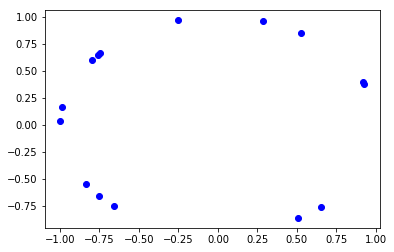

In [26]:
import matplotlib.pyplot as mpp
mpp.plot(x,y,'bo')
